# Reproduce the results of the paper (and supplementary)
In this notebook we firstly compare CoGS, GrowingSpheres, LORE, and Nelder-Mead on quality of retrived counterfactuals and time to obtain them. In doing so, we impose no plausibility constraints (not all methods support them).

Next, we focus on CoGS (with plausibility constraints activated) and assess the notions of robustness.

Start with some imports

In [76]:
import pandas as pd
import os, warnings, joblib
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set('paper', font_scale=1.67)

from cogs import util
from cogs.distance import gower_distance
from robust_cfe.dataproc import gimme
from robust_cfe.robustness import *

load_prev_dumps = True # to avoid expensive data analysis computations on the results
overall_seed = 42 # same as used in the experiments

Defining some helper functions

In [77]:
''' Load datasets (they include meta-info) '''
datasets = dict()
for dataset_name in ['credit','adult','boston','garments','compas']:
  datasets[dataset_name] = gimme(dataset_name, datasets_folder="../datasets")
  print(dataset_name, datasets[dataset_name]['X'].shape)

''' Load all results into one df '''
def load_df():
  candidate_folders = [os.path.join("../results/",x) for x in os.listdir('../results')]
  all_dfs = list()
  for folder in candidate_folders:
    fold_results = [os.path.join(folder,x) for x in os.listdir(folder) if x.startswith('result') and x.endswith('.csv')]
    curr_dfs = [pd.read_csv(f) for f in fold_results]
    for df in curr_dfs:
      df['method'] = folder.split('/')[-1].split('_')[5]
    all_dfs += curr_dfs
  df = pd.concat(all_dfs)
  df = df[df.overall_seed == overall_seed]
  df = df[df.dataset.isin(datasets.keys())]
  df.reset_index(inplace=True, drop=True)
  return df


''' Default dictionary for filtering a df '''
default_filter_dict={
  'check_plausibility':False, 
  'opt_C_robust':False, 
  'opt_K_robust':0
}


''' Filter the df according to provided features '''
def filter_df(df, filters=default_filter_dict):
  filtered_df = df.copy()
  for key in filters:
    filtered_df = filtered_df[filtered_df[key] == filters[key]]
  return filtered_df  


''' Check how many times counterfactuals are successfully found in a df '''
def counterfactual_discovery_success_rate(df, exclude_mispred_x=False):
  if len(df) == 0:
    warnings.warn("Warning: len(df)==0")
    return 0
  if exclude_mispred_x:
    curr_df = df[df.pred_class_x == df.true_class_x].copy()
  else:
    curr_df = df.copy()
  curr_df['success'] = (curr_df.desired_class == curr_df.pred_class_z).to_list()

  succ_rates = list()
  for fold_idx in curr_df.fold_idx.unique():
    n_successes = len(curr_df[(curr_df.fold_idx==fold_idx)&(curr_df.success == True)])
    total = len(curr_df[curr_df.fold_idx==fold_idx])
    succ_rates.append(n_successes/total)

  mean_sr = np.mean(succ_rates)
  std_sr = np.std(succ_rates)
  return mean_sr, std_sr


''' Fetch blackbox for a given data set and fold idx '''
def fetch_blackbox(dataset_name, fold_idx):
  path_blackbox = "../results/blackboxes/blackbox_prob_"+dataset_name+"_fold_"+str(fold_idx)+".joblib"
  blackbox = joblib.load(path_blackbox)
  return blackbox

''' Finds rows that correspond to the same case (dataset, fold_idx, rep_idx, x, etc.) '''
def find_corresponding_cases(row, df, ignore_rep_idx=True):
  cdf = df[(df.dataset == row.dataset) & (df.fold_idx == row.fold_idx) & 
    (df.test_sample_idx == row.test_sample_idx)].copy()
  if not ignore_rep_idx:
    cdf = cdf[cdf.rep_idx == row.rep_idx].copy()
  return cdf


''' Create a version of the df with only best-found out of multiple reps '''
def reduce_to_best_found(df, metric='loss', consider_only_successes=False):
  if consider_only_successes:
    curr_df = df[df.desired_class == df.pred_class_z]
  else:
    curr_df = df
  cols_to_group_by = ['blackbox_test_acc','method','test_sample_idx','fold_idx','dataset','check_plausibility','opt_C_robust','opt_K_robust']
  best_df = curr_df[curr_df[metric]==curr_df.groupby(cols_to_group_by)[metric].transform(min)].copy()
  # remove identical results that were found multiple times
  best_df.drop_duplicates(subset=cols_to_group_by, keep='first', inplace=True)
  return best_df


''' Fancy names dict for paper '''
fancy_names = {
  "cogs" : "CoGS",
  "cogs+P" : "CoGS+$\mathcal{P}$",
  "nelder-mead" : "NeMe",
  "lore" : "LORE",
  "growingspheres" : "GrSp",
  "boston" : "Hou",
  "credit" : "Cre",
  "compas" : "Rec",
  "adult" : "Inc",
  "garments" : "Pro"
}


credit (1000, 20)
adult (1883, 12)
boston (506, 13)
garments (1196, 12)
compas (2000, 10)


In [78]:
# loading all results
print("Loading data frame")
if load_prev_dumps and os.path.exists("df.joblib"):
  df = joblib.load("df.joblib")
else:
  df = load_df()
  # decorate by including gower distances
  print("... Reconstructing distances and losses")
  for i, row in df.iterrows():
    z = np.array(eval(row['z']))
    x = np.array(eval(row['x']))
    dataset_name = row.dataset
    feature_intervals = datasets[dataset_name]['feature_intervals']
    indices_categorical_features = datasets[dataset_name]['indices_categorical_features']
    num_feature_ranges = util.compute_ranges_numerical_features(feature_intervals, indices_categorical_features)
    gd = gower_distance(z, x, num_feature_ranges, indices_categorical_features)
    df.loc[i, 'gower_dist'] = gd
    l_0 = 1/len(x) * np.sum(z != x)
    is_not_cfe = 0 if row['pred_class_z'] == row['desired_class'] else 1
    loss = .5*gd + .5*l_0 + is_not_cfe
    df.loc[i, 'loss'] = loss
  print('done.')
  joblib.dump(df, "df.joblib", compress=3)

# let's consider only the best result out of five repetitions
df = reduce_to_best_found(df, metric='loss', consider_only_successes=False)

Loading data frame


## Report black box accuracy

In [79]:
# Get table for accuracy of black boxes for the data sets
print("\\toprule")
header = "{Fold} &"
for dataset_name in datasets:
  header += " {"+fancy_names[dataset_name]+"} &"
header = header[:-1] + "\\\\"
print(header)
print("\\midrule")
str_avg = "Avg."

for fold_idx in list(range(5)) + [str_avg]:
  if fold_idx == str_avg:
    print("\\hline")
  row_to_print = "{} &".format(fold_idx)
  if fold_idx != str_avg:
    for dataset_name in datasets:
      acc_fold_idx = df[(df.dataset == dataset_name) & (df.fold_idx == fold_idx)]['blackbox_test_acc'].unique()
      row_to_print += " {} &".format(np.round(acc_fold_idx, 2)[0])
  else:
    for dataset_name in datasets:
      acc_avg = df[(df.dataset == dataset_name)]['blackbox_test_acc'].mean()
      row_to_print += " {} &".format(np.round(acc_avg, 2))
  row_to_print = row_to_print[:-1] + " \\\\ "
  print(row_to_print)
print("\\bottomrule")

\toprule
{Fold} & {Cre} & {Inc} & {Hou} & {Pro} & {Rec} \\
\midrule
0 & 0.71 & 0.86 & 0.93 & 0.79 & 0.8  \\ 
1 & 0.78 & 0.82 & 0.9 & 0.77 & 0.82  \\ 
2 & 0.78 & 0.79 & 0.91 & 0.78 & 0.78  \\ 
3 & 0.74 & 0.82 & 0.91 & 0.82 & 0.77  \\ 
4 & 0.76 & 0.83 & 0.97 & 0.78 & 0.8  \\ 
\hline
Avg. & 0.76 & 0.83 & 0.93 & 0.79 & 0.8  \\ 
\bottomrule


## Success rate
We look at what methods are capable of effectively finding counterfactual examples (and how efficiently)

In [56]:
# Create table of success rates
# Get table for accuracy of black boxes for the data sets
print("\\toprule")
header = "{Alg.} &"
for dataset_name in datasets:
  header += " {"+fancy_names[dataset_name]+"} &"
header = header[:-1] + "\\\\"
print(header)
print("\\midrule")
for method in ['cogs','growingspheres','lore','nelder-mead']:
  row_to_print = "{} &".format(fancy_names[method])
  for dataset_name in datasets:
    curr_filters = default_filter_dict.copy()
    curr_filters['method'] = method
    curr_filters['dataset'] = dataset_name
    fdf = filter_df(df, filters=curr_filters)
    m_sr, s_sr = np.round(counterfactual_discovery_success_rate(fdf),2)
    row_to_print += " {:.2f} ({}) &".format(m_sr, int(np.round(s_sr,2)*100))
  row_to_print = row_to_print[:-1] + " \\\\ "
  print(row_to_print)
print("\\bottomrule")

\toprule
{Alg.} & {Cre} & {Inc} & {Hou} & {Pro} & {Rec} \\
\midrule
CoGS & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
GrSp & 0.46 (11) & 0.89 (6) & 1.00 (0) & 0.86 (4) & 0.30 (15)  \\ 
LORE & 0.56 (20) & 0.20 (13) & 0.68 (20) & 0.24 (20) & 0.60 (38)  \\ 
NeMe & 0.08 (3) & 0.05 (2) & 0.04 (5) & 0.03 (1) & 0.14 (2)  \\ 
\bottomrule


Let's see the running times of these algorithms

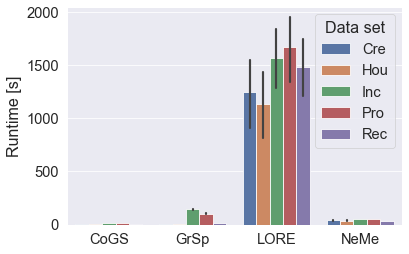

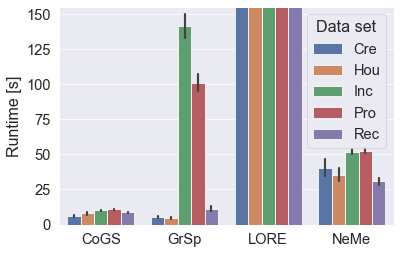

In [57]:
fdf = filter_df(df, filters=default_filter_dict)
# some re-naming
fdf['Data set'] = [fancy_names[x] for x in fdf.dataset.to_list()]
fdf['Method'] = [fancy_names[x] for x in fdf.method.to_list()]
fdf['Runtime [s]'] = fdf.run_time
fdf.sort_values(by=['Data set','Method'], inplace=True)
fig, ax = plt.subplots()
ax = sns.barplot(x='Method', y='Runtime [s]', hue='Data set', data=fdf)
ax.set_xlabel('')
plt.show()
fig.tight_layout()
fig.savefig(fname="running_times_algorithms.pdf")

fig, ax = plt.subplots()
ax = sns.barplot(x='Method', y='Runtime [s]', hue='Data set', data=fdf)
ax.set_xlabel('')
ax.set_ylim(0, 155)
plt.show()
fig.tight_layout()
fig.savefig(fname="running_times_algorithms_zoomin.pdf")


Check distances w.r.t. those of CoGS

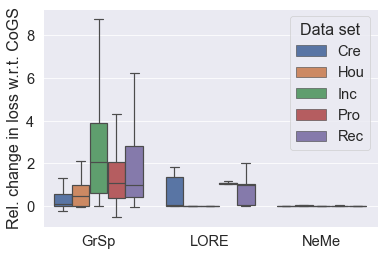

In [58]:
if load_prev_dumps and os.path.exists("methods_vs_cogs.joblib"):
  fdf = joblib.load("methods_vs_cogs.joblib")
else:
  fdf = filter_df(df, filters=default_filter_dict)
  # only successes
  fdf = fdf[fdf.pred_class_z == fdf.desired_class]
  fdf.reset_index(inplace=True, drop=True)
  fdf_cogs = fdf[fdf.method == 'cogs']
  # compute dist w.r.t. cogs
  for index, row in fdf.iterrows():
    cdf = find_corresponding_cases(row, fdf_cogs, ignore_rep_idx=True)
    assert(len(cdf) == 1)
    this_loss = float(row['loss'])
    cogs_loss = float(cdf['loss'])
    fdf.loc[index,'this_loss_over_cogs_loss'] = this_loss / cogs_loss
    fdf.loc[index, 'rel_loss_change_wrt_cogs'] = (this_loss - cogs_loss)/cogs_loss
  joblib.dump(fdf, "methods_vs_cogs.joblib", compress=3)

# some re-naming
fdf = fdf[fdf['method'] != 'cogs']
fdf['Data set'] = [fancy_names[x] for x in fdf.dataset.to_list()]
fdf['Algorithm'] = [fancy_names[x] for x in fdf.method.to_list()]
fdf['Relative change loss'] = fdf['rel_loss_change_wrt_cogs']

fdf.sort_values(by=['Data set','Algorithm'], inplace=True)
fig, ax = plt.subplots()
ax = sns.boxplot(x='Algorithm', y='Relative change loss', hue='Data set', data=fdf, showfliers=False)
ax.set_xlabel('')
#ax.set_xticks([])
ax.set_ylabel("Rel. change in loss w.r.t. CoGS")
plt.show()
fig.tight_layout()
fig.savefig(fname="additional_cost_algorithms.pdf")


## CoGS is the best method 
We focus on CoGS in the following...

Check whether success rate is impacted by plausibility etc

In [59]:
# No plaus vs plaus, c, k
filter_dict = default_filter_dict.copy()
filter_dict['check_plausibility'] = False
filter_dict['method'] = 'cogs'

# Plaus OFF, no robustness
fdf_base = filter_df(df, filters=filter_dict)

# Plaus ON
filter_dict['check_plausibility'] = True
fdf_p = filter_df(df, filters=filter_dict)

# Plaus ON, C robustness
filter_dict['opt_C_robust'] = True
fdf_p_c = filter_df(df, filters=filter_dict)

# Plaus ON, K robustness at different m
filter_dict['opt_C_robust'] = False
filter_dict['opt_K_robust'] = 4
fdf_p_k4 = filter_df(df, filters=filter_dict)
filter_dict['opt_K_robust'] = 16
fdf_p_k16 = filter_df(df, filters=filter_dict)
filter_dict['opt_K_robust'] = 64
fdf_p_k64 = filter_df(df, filters=filter_dict)

# Plaus ON, C & K robustness at different m
filter_dict['opt_C_robust'] = True
filter_dict['opt_K_robust'] = 4
fdf_p_c_k4 = filter_df(df, filters=filter_dict)
filter_dict['opt_K_robust'] = 16
fdf_p_c_k16 = filter_df(df, filters=filter_dict)
filter_dict['opt_K_robust'] = 64
fdf_p_c_k64 = filter_df(df, filters=filter_dict)


In [60]:
# Create table of success rates across different configs
print("\\toprule")
header = "{Criteria} &"
for dataset_name in datasets:
  header += " {"+fancy_names[dataset_name]+"} &"
header = header[:-1] + "\\\\"
print(header)
print("\\midrule")
for method in ["p", "base", "p_c", "p_k", "p_c_k"]:
  if method == 'base':
    curr_df = fdf_base
    m_name = " No $\\mathcal{P}$"
  elif method == "p":
    curr_df = fdf_p
    m_name = " None"
  elif method == "p_c":
    curr_df = fdf_p_c
    m_name = " $\\mathcal{C}$"
  elif method == "p_k":
    curr_df = fdf_p_k64
    m_name = " $\\mathcal{K}$"
  elif method == "p_c_k":
    curr_df = fdf_p_c_k64
    m_name = " $\\mathcal{C}, \\mathcal{K}$"
    
  row_to_print = "{} &".format(m_name)
  for dataset_name in datasets:
    curr_df_2 = curr_df[curr_df.dataset == dataset_name].copy()
    mean_sr, std_sr = counterfactual_discovery_success_rate(curr_df_2)
    row_to_print += " {:.2f} ({}) &".format(np.round(mean_sr,2), int(np.round(std_sr,2)*100) )
  row_to_print = row_to_print[:-1] + " \\\\ "
  print(row_to_print)
print("\\bottomrule")

\toprule
{Criteria} & {Cre} & {Inc} & {Hou} & {Pro} & {Rec} \\
\midrule
 None & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
 No $\mathcal{P}$ & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
 $\mathcal{C}$ & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
 $\mathcal{K}$ & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
 $\mathcal{C}, \mathcal{K}$ & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0) & 1.00 (0)  \\ 
\bottomrule


# Robustness
We now investigate robustness. (We always use plausibility contraints ON from now on.)

## Optimal C-robustness & K-robustness
Let's assess if CoGS "happens" to generate optimal C-robust CFEs or K-robust CFEs. To do this, let's focus on the best-found point out of the 5 repetitions. We compare if best-found points match when optimizing for C-setbacks are OFF and ON, and when optimizing for B-robustness (with m=64).

In [61]:
print("\\toprule")
header = "{Comparison} & {Tol.} & "
for dataset_name in datasets:
  header += " {"+fancy_names[dataset_name]+"} &"
header = header[:-1] + "\\\\"
print(header)
print("\\midrule")

for robust_type in ['C','K','CK']:
  multirow = "\multirow{3}{*}{None vs.~"
  if robust_type == 'C':
    multirow += "$\\mathcal{C}$"
  elif robust_type == 'K':
    multirow += "$\\mathcal{K}$"
  elif robust_type == 'CK':
    multirow += "$\\mathcal{C},\\mathcal{K}$"
  multirow += "}"

  print(multirow)

  for tol in [0.01, 0.05, 0.10]:
    tol_row = " & {}\\% &".format(int(tol*100))

    for dataset_name in datasets:
      curr_filters = default_filter_dict.copy()
      curr_filters['dataset'] = dataset_name
      curr_filters['method'] = 'cogs'
      curr_filters['check_plausibility'] = True
      
      nonrobust_df = filter_df(df, filters=curr_filters)

      if robust_type == 'C':
        curr_filters['opt_C_robust'] = True
      elif robust_type == 'K':
        curr_filters['opt_K_robust'] = 64
      elif robust_type == 'CK':
        curr_filters['opt_C_robust'] = True
        curr_filters['opt_K_robust'] = 64

      robust_df = filter_df(df, filters=curr_filters)

      # take average across 5 folds
      across_fold_matches = list()
      for fold_idx in nonrobust_df.fold_idx.unique():
        nr_fold_df = nonrobust_df[nonrobust_df.fold_idx == fold_idx]
        r_fold_df = robust_df[robust_df.fold_idx == fold_idx]

        # take intersection of the two data frames
        X_in_common = pd.Series(list(set(r_fold_df['x']) & set(nr_fold_df['x'])))
        nr_fold_df = nr_fold_df[nr_fold_df['x'].isin(X_in_common)].copy()
        r_fold_df = r_fold_df[r_fold_df['x'].isin(X_in_common)].copy()
        assert(len(nr_fold_df) == len(r_fold_df))

        # sort the data frames by x
        nr_fold_df.sort_values(by=['x','fold_idx'], inplace=True)
        r_fold_df.sort_values(by=['x','fold_idx'], inplace=True)

        # take x's and z's
        X = nr_fold_df['x'].to_list()
        nonrobust_Z = nr_fold_df['z'].to_list()
        robust_Z = r_fold_df['z'].to_list()

        count_match = 0
        for i in range(len(X)):
          x = np.array(eval(X[i]))
          z_nr = np.array(eval(nonrobust_Z[i]))
          z_r = np.array(eval(robust_Z[i]))
          count_match += is_same_point(z_nr, z_r, x, datasets[dataset_name]['feature_intervals'], datasets[dataset_name]['indices_categorical_features'], tol=tol)
        #print('   tol: {}, matches (%): {}'.format(tol, np.round(count_match / len(X),3)))
        across_fold_matches.append(count_match / len(X))

      m_matches, s_matches = np.mean(across_fold_matches), np.std(across_fold_matches)
      tol_row += " {:.2f} ({}) &".format(np.round(m_matches,2),int(np.round(s_matches*100)))
    
    tol_row = tol_row[:-1] + "\\\\"

    print(tol_row)
  print("\\bottomrule")


\toprule
{Comparison} & {Tol.} &  {Cre} & {Inc} & {Hou} & {Pro} & {Rec} \\
\midrule
\multirow{3}{*}{None vs.~$\mathcal{C}$}
 & 1\% & 0.40 (6) & 0.02 (0) & 0.76 (10) & 0.53 (5) & 0.27 (6) \\
 & 5\% & 0.42 (7) & 0.04 (2) & 0.84 (9) & 0.57 (6) & 0.37 (7) \\
 & 10\% & 0.43 (7) & 0.05 (2) & 0.85 (9) & 0.58 (6) & 0.40 (9) \\
\bottomrule
\multirow{3}{*}{None vs.~$\mathcal{K}$}
 & 1\% & 0.37 (1) & 0.06 (2) & 0.33 (24) & 0.26 (5) & 0.04 (4) \\
 & 5\% & 0.44 (3) & 0.40 (8) & 0.63 (17) & 0.37 (6) & 0.08 (3) \\
 & 10\% & 0.46 (4) & 0.58 (7) & 0.67 (16) & 0.46 (7) & 0.12 (2) \\
\bottomrule
\multirow{3}{*}{None vs.~$\mathcal{C},\mathcal{K}$}
 & 1\% & 0.23 (4) & 0.00 (0) & 0.21 (21) & 0.19 (6) & 0.03 (3) \\
 & 5\% & 0.27 (3) & 0.00 (0) & 0.54 (21) & 0.26 (5) & 0.06 (4) \\
 & 10\% & 0.30 (5) & 0.00 (0) & 0.60 (19) & 0.34 (6) & 0.08 (4) \\
\bottomrule


## Further info on K robustness using different m's
For K robustness, check how well we fare when comparing with a "more serious" assessment of K robustness, that use many samples

In [62]:
# Compare the chosen settings for "serious" K robustness assessment
def get_K_robustness_scores(check_plausibility=True, consider_opt_C_robust=False):
  print("Considering: check_plaus={}, consider_opt_C_robust={}".format(
      check_plausibility, consider_opt_C_robust))

  all_results = dict()

  for dataset_name in datasets:
    print(' ',dataset_name)

    result_df = pd.DataFrame(columns=('k','k_score'))

    # to avoid loading blackboxes every time
    blackboxes_cache = dict()

    curr_filters = default_filter_dict.copy()
    curr_filters['method'] = 'cogs'
    curr_filters['dataset'] = dataset_name
    curr_filters['check_plausibility'] = check_plausibility

    base_best_df = filter_df(df, filters=curr_filters) # get base as df without C nor K (but with P)

    curr_filters['opt_C_robust'] = consider_opt_C_robust

    for k in [0,4,16,64]:
      print('   k =',k)
      curr_filters['opt_K_robust'] = k
      fdf = filter_df(df, filters=curr_filters)

      def get_k_robustness_score(row, n_samples=1000):
        z = np.array(eval(row['z']))
        x = np.array(eval(row['x']))
        fold_idx = row['fold_idx']
        if fold_idx not in blackboxes_cache:
          blackbox = fetch_blackbox(dataset_name, fold_idx)
          blackboxes_cache[fold_idx] = blackbox
        
        k_robustness_score = compute_K_robustness_score(z, x, datasets[dataset_name]['perturbations'], blackboxes_cache[fold_idx], 
          datasets[dataset_name]['feature_intervals'], datasets[dataset_name]['indices_categorical_features'], n_samples=n_samples)

        return k_robustness_score

      # compute stats w.r.t. cogs
      rel_changes_loss = list()
      rel_changes_runtime = list()
      k_rob_scores = list()
      for _, row in fdf.iterrows():
        cdf = find_corresponding_cases(row, base_best_df)
        if len(cdf) < 1:
          continue
        assert(len(cdf) == 1)

        this_loss = float(row['loss'])
        base_loss = float(cdf['loss'])
        additional_cost = (this_loss - base_loss) / base_loss

        this_runtime = float(row['run_time'])
        cogs_runtime = float(cdf['run_time'])
        additional_runtime = (this_runtime - cogs_runtime) / cogs_runtime

        rel_changes_loss.append(additional_cost)
        rel_changes_runtime.append(additional_runtime)
        k_rob_scores.append(get_k_robustness_score(row))
      
      curr_result_df = pd.DataFrame.from_dict({'k':[k]*len(k_rob_scores), 
        'k_score':k_rob_scores})
        
      result_df = result_df.append(curr_result_df, ignore_index=True)

    # now plot this
    all_results[dataset_name] = result_df

  return all_results

In [63]:
if load_prev_dumps and os.path.exists("results_k_robustness.joblib"):
  results_k = joblib.load("results_k_robustness.joblib")
else:
  results_k = get_K_robustness_scores(True,False)
  joblib.dump(results_k,"results_k_robustness.joblib", compress=3)  

Now also consider the case in which C is optimized for

In [64]:
## Like before, but also with C
if load_prev_dumps and os.path.exists("results_k_robustness_wC.joblib"):
  results_k_c = joblib.load("results_k_robustness_wC.joblib")
else:
  results_k_c = get_K_robustness_scores(True,True)
  joblib.dump(results_k_c,"results_k_robustness_wC.joblib", compress=3)  

credit
adult
boston
garments
compas


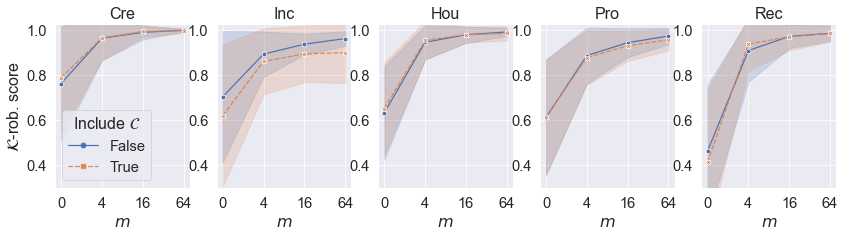

In [65]:
# Make a plot
fig, axs = plt.subplots(1,len(datasets), figsize=(14,3))

min_y = 1.0
for i, dataset_name in enumerate(datasets):
  print(dataset_name)

  curr_df_noC = results_k[dataset_name]
  curr_df_noC['Include $\\mathcal{C}$'] = False
  curr_df_wC = results_k_c[dataset_name]
  curr_df_wC['Include $\\mathcal{C}$'] = True

  curr_df = pd.concat([curr_df_noC, curr_df_wC], axis=0)
  curr_df['$m$'] = curr_df['k']
  curr_df['$m$'].replace([0,4,16,64],[0,1,2,3], inplace=True)
  curr_df['$\\mathcal{K}$-rob. score'] = curr_df['k_score']
  curr_df.reset_index(drop=True, inplace=True)
  sns.lineplot(x='$m$',y='$\\mathcal{K}$-rob. score', data=curr_df, ci='sd',
    ax=axs[i], style='Include $\\mathcal{C}$', hue='Include $\\mathcal{C}$', markers=True, dashes=True, 
    legend=i==0)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xticks([0,1,2,3])
  axs[i].set_xticklabels([0,4,16,64])
  if i != 0:
    axs[i].set_ylabel('')

for ax_i in axs:
  ax_i.set_ylim(0.3,1.025)  
  
plt.show()
fig.tight_layout()
fig.savefig('increasing_m_krobustness.pdf')

## Additional search cost and entailed cost
We now try to answer the questions: 
- how expensive is it to search for robust counterfactual examples?
- what's the additional cost (Gower distance) associated with robust counterfactual examples?

In [66]:
# compute additional cost (loss & runtime)
def get_add_cost(check_plausibility=True, consider_opt_C_robust=False):
  print("Considering: check_plaus={}, consider_opt_C_robust={}".format(
      check_plausibility, consider_opt_C_robust))

  all_results = dict()

  for dataset_name in datasets:
    print(' ',dataset_name)

    result_df = pd.DataFrame(columns=('k','additional_cost', 'additional_runtime', 'rel_add_cost', 'Include $\\mathcal{C}$', 'dataset'))

    curr_filters = default_filter_dict.copy()
    curr_filters['method'] = 'cogs'
    curr_filters['dataset'] = dataset_name
    curr_filters['check_plausibility'] = check_plausibility

    base_best_df = filter_df(df, filters=curr_filters) # get base as df without C nor K (but with P)

    curr_filters['opt_C_robust'] = consider_opt_C_robust

    for k in [0,4,16,64]:
      curr_filters['opt_K_robust'] = k
      fdf = filter_df(df, filters=curr_filters)

      # focus on successful cases
      best_df = fdf[fdf.desired_class == fdf.pred_class_z]

      # take intersection
      X_in_common = pd.Series(list(set(best_df['x']) & set(base_best_df['x'])))
      curr_best_df = best_df[best_df['x'].isin(X_in_common)].copy()
      curr_base_best_df = base_best_df[base_best_df['x'].isin(X_in_common)].copy()
      assert(len(curr_best_df) == len(curr_base_best_df))

      # sort the data frames by x
      curr_base_best_df.sort_values(by=['x','fold_idx'], inplace=True)
      curr_best_df.sort_values(by=['x','fold_idx'], inplace=True)

      add_cost = curr_best_df['loss'].to_numpy() - curr_base_best_df['loss'].to_numpy()
      rel_add_cost = np.divide(curr_best_df['loss'].to_numpy(), curr_base_best_df['loss'].to_numpy())
      add_runtime = curr_best_df['run_time'].to_numpy() - curr_base_best_df['run_time'].to_numpy()

      
      curr_result_df = pd.DataFrame.from_dict({'k':[k]*len(add_cost), 
        'additional_cost':add_cost,
        'rel_add_cost' : rel_add_cost,
        'additional_runtime': add_runtime})

      curr_result_df["Include $\\mathcal{C}$"] = consider_opt_C_robust
      curr_result_df["dataset"] = dataset_name
      result_df = result_df.append(curr_result_df, ignore_index=True)

    all_results[dataset_name] = result_df

  return all_results

add_cost_k = get_add_cost(True,False)
add_cost_k_c = get_add_cost(True,True)

Considering: check_plaus=True, consider_opt_C_robust=False
  credit
  adult
  boston
  garments
  compas
Considering: check_plaus=True, consider_opt_C_robust=True
  credit
  adult
  boston
  garments
  compas


Additional cost


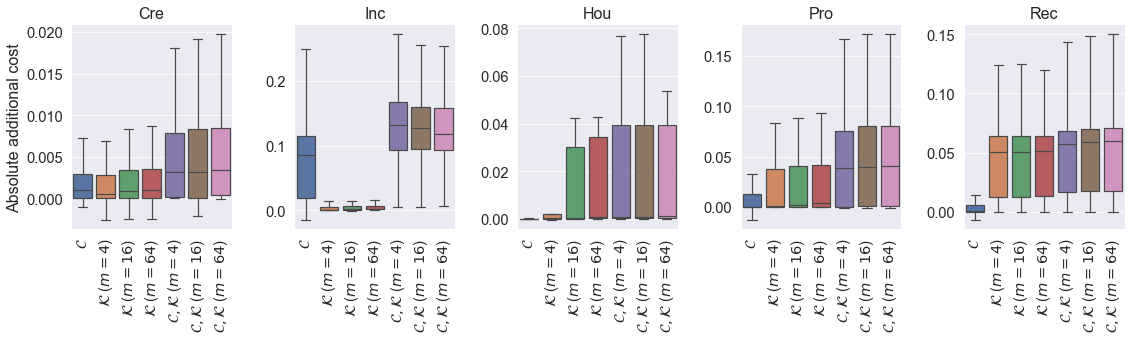

Rel. additional cost


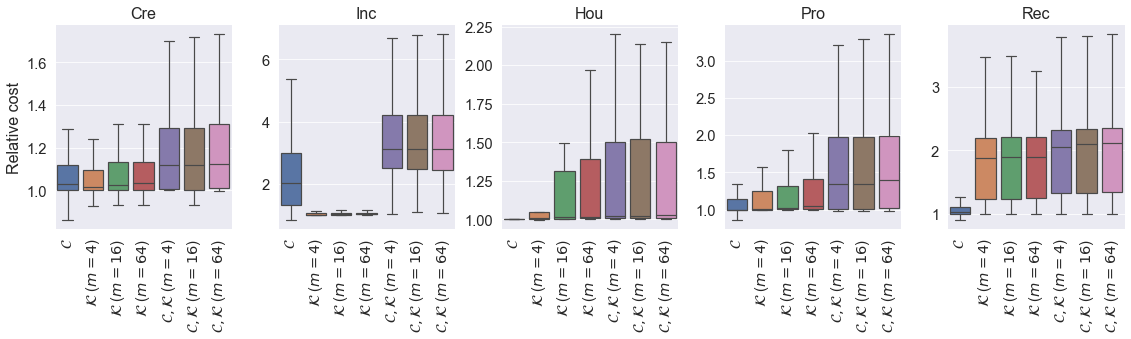

Additional runtime


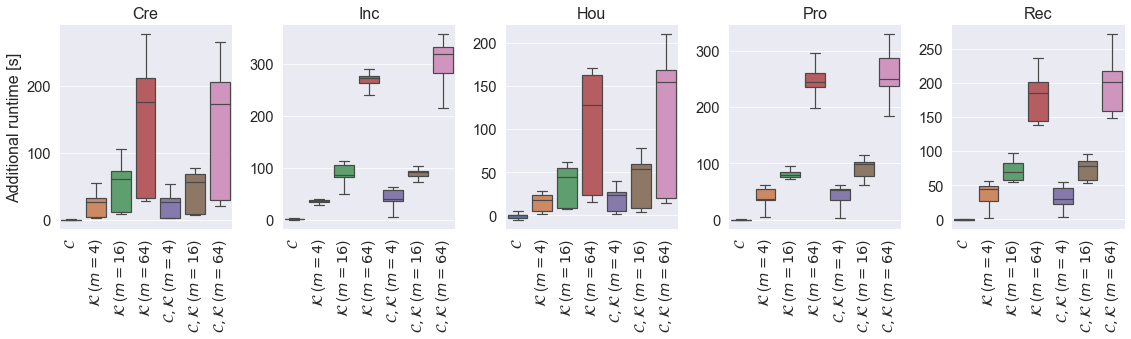

In [67]:
# let's assemble result_k and result_k_c into a data frame
cost_df = None

for dataset_name in datasets:
  noC_df = add_cost_k[dataset_name]
  wC_df = add_cost_k_c[dataset_name]
  if cost_df is None:
    cost_df = pd.concat([noC_df, wC_df], axis=0)
  else:
    cost_df = pd.concat([cost_df, noC_df, wC_df], axis=0)

# set names for the types of robustness to display
# and also a sorting order for the plots
cost_df.loc[(cost_df.k==0)&(cost_df["Include $\\mathcal{C}$"]==True), 'Robustness type'] = "$\\mathcal{C}$"
cost_df.loc[cost_df["Robustness type"] == "$\\mathcal{C}$", 'sort_order'] = 0

cost_df.loc[(cost_df.k!=0)&(cost_df["Include $\\mathcal{C}$"]==False), 'Robustness type'] = "$\\mathcal{K}$ ($m=" + cost_df[(cost_df.k!=0)&(cost_df["Include $\\mathcal{C}$"]==False)]['k'].astype(str) + "$)"
for i, k in enumerate([0,4,16,64]):
  cost_df.loc[cost_df["Robustness type"] == "$\\mathcal{K}$ ($m="+str(k)+"$)", 'sort_order'] = i+1

cost_df.loc[(cost_df.k!=0)&(cost_df["Include $\\mathcal{C}$"]==True), 'Robustness type'] = "$\\mathcal{C}, \\mathcal{K}$ ($m=" + cost_df[(cost_df.k!=0)&(cost_df["Include $\\mathcal{C}$"]==True)]['k'].astype(str) + "$)"
for i, k in enumerate([0,4,16,64]):
  cost_df.loc[cost_df["Robustness type"] == "$\\mathcal{C}, \\mathcal{K}$ ($m="+str(k)+"$)", 'sort_order'] = i+5

cost_df.sort_values("sort_order", axis=0, inplace=True)

print("Additional cost")
fig, axs = plt.subplots(1,len(datasets), figsize=(16,5))
for i, dataset_name in enumerate(datasets):
  curr_df = cost_df[cost_df.dataset == dataset_name]
  sns.boxplot(x="Robustness type", y="additional_cost", data=curr_df, ax=axs[i], 
    showfliers=False)
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xlabel("")
  axs[i].set_ylabel("Absolute additional cost")
  if i != 0:
    axs[i].set_ylabel("")
fig.tight_layout()
fig.savefig("abs_addcost_robustness.pdf")
plt.show()

print("Rel. additional cost")
fig, axs = plt.subplots(1,len(datasets), figsize=(16,5))
for i, dataset_name in enumerate(datasets):
  curr_df = cost_df[cost_df.dataset == dataset_name]
  sns.boxplot(x="Robustness type", y="rel_add_cost", data=curr_df, ax=axs[i], 
    showfliers=False)
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xlabel("")
  axs[i].set_ylabel("Relative cost")
  if i != 0:
    axs[i].set_ylabel("")
fig.tight_layout()
fig.savefig("rel_addcost_robustness.pdf")
plt.show()

print("Additional runtime")
fig, axs = plt.subplots(1,len(datasets), figsize=(16,5))
for i, dataset_name in enumerate(datasets):
  curr_df = cost_df[cost_df.dataset == dataset_name]
  sns.boxplot(x="Robustness type", y="additional_runtime", data=curr_df, ax=axs[i], 
    showfliers=False)
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=90)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xlabel("")
  axs[i].set_ylabel("Additional runtime [s]")
  if i != 0:
    axs[i].set_ylabel("")
fig.tight_layout()
fig.savefig("additional_runtime_robustness.pdf")
plt.show()

## Invalidity & actual cost if bad perturbations happen but were not accounted for

First we define a couple of helper functions

In [68]:
def check_setback_is_fixable(setback, plaus_c, indices_categorical_features):
  is_not_fixable = False
  for i in range(len(setback)):
    if plaus_c[i] is None:
      continue
    
    if i in indices_categorical_features:
      if setback[i] != 0 and plaus_c[i] == '=':
        is_not_fixable = True
        break
    else:
      if setback[i] < 0 and (plaus_c[i] == '<=' or plaus_c[i] == '='):
        is_not_fixable = True
        break
      elif setback[i] > 0 and (plaus_c[i] == '>=' or plaus_c[i] == '='):
        is_not_fixable = True
        break
  is_fixable = not is_not_fixable
  return is_fixable

In [69]:
def compute_worst_K_setbacks(Z, x, perturb, indices_categorical_features=None):
  is_single_candidate = len(Z.shape) == 1

  if is_single_candidate:
    Z = Z.reshape((1,-1))

  setbacks = np.zeros(Z.shape)

  # compute signs as per definition of worst-case in the paper
  signs = np.sign(Z-x)
  for i in range(len(x)):
    
    # skip perturbations that cannot happen
    if perturb[i] is None:
      continue

    if indices_categorical_features is not None and i in indices_categorical_features:
      # for gower it does not matter for what the mismatch is
      # let's set a magnitude of setback of 1 (category mismatch)
      setbacks[:,i] = np.where(signs[:,i] == 0, 1, setbacks[:,i])
    else:
      # numerical feature

      # consider decrease or increase, take largest
      if perturb[i]['type'] == 'absolute':
        perturb_decrease = perturb[i]['decrease']
        perturb_increase = perturb[i]['increase']
      else: # relative
        perturb_decrease = perturb[i]['decrease'] * Z[:,i]
        perturb_increase = perturb[i]['increase'] * Z[:,i]

        assert((perturb_decrease.reshape((-1,1)) >= 0).all() and (perturb_increase.reshape((-1,1)) >=0).all())

      applied_perturbations = np.where(perturb_decrease > perturb_increase, perturb_decrease, perturb_increase)
      
      # consider Perturbations toly where z==x (K-robustness)
      setbacks[:,i] = np.where(signs[:,i] == 0, applied_perturbations, setbacks[:,i])
      # note: no changes are made for the case signs!=0 (as the feature is not in K)

  if is_single_candidate:
    setbacks = setbacks[0]
  
  return setbacks

In [70]:
def get_actual_cost_when_unlucky(n_samples=100):

  result_df = None

  for dataset_name in datasets:
    print(dataset_name)

    blackboxes_cache = dict() # to avoid loading a black-box every time

    curr_filters = default_filter_dict.copy()
    curr_filters['method'] = 'cogs'
    curr_filters['dataset'] = dataset_name
    curr_filters['check_plausibility'] = True

    for is_C_robust in [False, True]:
      for is_K_robust in [0, 64]:

        curr_filters['opt_C_robust'] = is_C_robust
        curr_filters['opt_K_robust'] = is_K_robust

        feature_intervals = datasets[dataset_name]['feature_intervals']
        indices_categorical_features = datasets[dataset_name]['indices_categorical_features']
        perturbations = datasets[dataset_name]['perturbations']
        plaus_c = datasets[dataset_name]['plausibility_constraints']
        num_feature_ranges = util.compute_ranges_numerical_features(feature_intervals, indices_categorical_features)
        
        curr_df = filter_df(df, filters=curr_filters) # get base as df without C nor K (but with P)
        curr_df.reset_index(drop=True, inplace=True)

        for idx, row in curr_df.iterrows():
          x = np.array(eval(row['x']))
          z = np.array(eval(row['z']))

          fold_idx = row['fold_idx']
          if fold_idx not in blackboxes_cache:
            blackbox = fetch_blackbox(dataset_name, fold_idx)
            blackboxes_cache[fold_idx] = blackbox

          # We consider both worst and avg. cases.

          # First, C
          # Compute the worst-case C-setback as starting point
          w_setback_C = compute_worst_C_setbacks(z, x, perturbations, indices_categorical_features)
          
          # by construction, theoretically we do not need to call the black-box here, nor fixability should ever be false
          w_fixable_C = check_setback_is_fixable(w_setback_C, plaus_c, indices_categorical_features)
          assert(w_fixable_C is True)

          # We proceed with computing random perturbations.
          # We do this by simply sampling magnitudes between 0 and the corrsp. one from the worst-case C-setback.
          # Since CoGS does not have optimality guarantees, it could be that, for small setbacks,
          # the desired class is still found. In those cases, we do not account for extra cost to be needed.
          rand_setbacks_C = w_setback_C*np.random.random(size=(n_samples,len(w_setback_C)))
          Z_rand_setbacks_C = z + rand_setbacks_C
          L_rand_setbacks_C = blackbox.predict(Z_rand_setbacks_C) 

          # Invalidity (*after* putting additional cost)
          # Theoretically under optimal z^*, a C-setback always makes it invalid. 
          # But here z^* is not necessarily optimal and a C-setback may be small, or simply a C-setback may be null 
          # (e.g., "make the user younger" is not a possible perturbation)
          curr_df.loc[idx, 'avg_invalidity_C'] = np.mean(L_rand_setbacks_C != row['desired_class'])
          

          # Additional cost
          # Theoretically, fixing C-setbacks is always possible, no need to check that. Let's compute the additional cost.
          # The term about Gower's dist needs to include a ||w||_1, while the L0-term does not change (we still pursue the original plan)
          rand_setbacks_C_contrib = np.sum(np.abs(rand_setbacks_C), axis=1) / len(x)
          # ignore cases where the setback was not harmful (can only happen due to lack of optimality of z^\star!)
          rand_setbacks_C_contrib = np.where(L_rand_setbacks_C != float(row['desired_class']), rand_setbacks_C_contrib, 0)
          # since in the loss the Gower's dist term is multiplied by .5, we must do the same 
          avg_actual_cost_C = row['loss'] + .5*np.mean(rand_setbacks_C_contrib)
          curr_df.loc[idx, 'avg_actual_cost_C'] = avg_actual_cost_C


          # Second, K
          # First we generate the K-neighborhood
          Z_neigh = generate_K_neighborhood(z, x, perturbations, feature_intervals, indices_categorical_features, n_samples)
          # Next, we look at the labels (we do not worry about K-neighbors that are classified as the desired class c^*)
          L_neigh = blackbox.predict(Z_neigh)

          # Let's measure invalidity
          curr_df.loc[idx, 'avg_invalidity_K'] = np.mean(L_neigh != row['desired_class'])
          
          # Additional cost
          # First, it is not always plausible to fix a setback in K! So we need to check that

          problematic = list()
          fixabilities_K = list()
          for i, z_neigh in enumerate(Z_neigh):
            # ignore if not a problem
            if L_neigh[i] == row["desired_class"]:
              fixabilities_K.append(True)
              continue
            problematic.append(i)
            # else check if it is fixable
            setback = z_neigh - z
            fixable = check_setback_is_fixable(setback, plaus_c, indices_categorical_features)
            fixabilities_K.append(fixable)
          fixabilities_K = np.array(fixabilities_K, dtype=bool)
          curr_df.loc[idx, 'avg_actual_fixable_K'] = np.mean(fixabilities_K)

          # Finally we consider the distance to compute the additional cost
          # in doing so, we exclude non-problematic z-neighbors but also non-fixable ones
          gds = gower_distance(Z_neigh, z, num_feature_ranges, indices_categorical_features)
          l_0s = 1/len(x) * np.sum(Z_neigh != z, axis=1) # to act to fix perturbs in z, L0 must be also considered
          dists = .5*gds + .5*l_0s
          dists = dists[problematic]
          if len(dists) == 0:
            #print("Warning: No K-neighbor was of a different class than c* on {}, fold {}, row {}".format(dataset_name,fold_idx,idx))
            pass

          avg_actual_cost_K = row['loss'] + (np.mean(dists) if len(dists) > 0 else 0)
          curr_df.loc[idx, 'avg_actual_cost_K'] = avg_actual_cost_K
        
          # Finally, C & K at the same time 
          avg_actual_cost_CK = avg_actual_cost_C + avg_actual_cost_K - row['loss']
          curr_df.loc[idx, 'avg_actual_cost_CK'] = avg_actual_cost_CK
          # invalidity
          L_CK = blackbox.predict(Z_neigh + rand_setbacks_C)
          curr_df.loc[idx, 'avg_invalidity_CK'] = np.mean(L_CK != row['desired_class'])
          fixabilities_CK = fixabilities_K.copy() # by construction
          curr_df.loc[idx, 'avg_actual_fixable_CK'] = np.mean(fixabilities_CK)
      
        if result_df is None:
          result_df = curr_df
        else:
          result_df = pd.concat([result_df,curr_df])
      
  return result_df



In [71]:
if load_prev_dumps and os.path.exists("actual_cost_when_unlucky.joblib"):
  act_cost_df = joblib.load("actual_cost_when_unlucky.joblib")
else:
  act_cost_df = get_actual_cost_when_unlucky(100)
  joblib.dump(act_cost_df, "actual_cost_when_unlucky.joblib", compress=3)

act_cost_df['rel_avg_act_cost_C'] = act_cost_df['avg_actual_cost_C'] / act_cost_df['loss']
act_cost_df['rel_avg_act_cost_K'] = act_cost_df['avg_actual_cost_K'] / act_cost_df['loss']
act_cost_df['rel_avg_act_cost_CK'] = act_cost_df['avg_actual_cost_CK'] / act_cost_df['loss']

act_cost_df['abs_avg_act_cost_C'] = act_cost_df['avg_actual_cost_C'] - act_cost_df['loss']
act_cost_df['abs_avg_act_cost_K'] = act_cost_df['avg_actual_cost_K'] - act_cost_df['loss']
act_cost_df['abs_avg_act_cost_CK'] = act_cost_df['avg_actual_cost_CK'] - act_cost_df['loss']

In [72]:
# Rearrange info for plotting
act_cost_df2 = None
act_cost_df["Robust. type"] = "Dummy"
for robust_type in [None, 'C','K','CK']:
  for perturb_type in ['C','K','CK']:
    if robust_type is None:
      curr_df = act_cost_df[(act_cost_df.opt_C_robust == False)&(act_cost_df.opt_K_robust==0)].copy()
      curr_df["Robust. type"] = "None"
    elif robust_type == "C":
      curr_df = act_cost_df[(act_cost_df.opt_C_robust == True)&(act_cost_df.opt_K_robust==0)].copy()
      curr_df["Robust. type"] = "Only $\\mathcal{C}$"
    elif robust_type == "K":
      curr_df = act_cost_df[(act_cost_df.opt_C_robust == False)&(act_cost_df.opt_K_robust==64)].copy()
      curr_df["Robust. type"] = "Only $\\mathcal{K}$"
    elif robust_type == "CK":
      curr_df = act_cost_df[(act_cost_df.opt_C_robust == True)&(act_cost_df.opt_K_robust==64)].copy()
      curr_df["Robust. type"] = "Both $\\mathcal{C}, \\mathcal{K}$"

    if perturb_type == 'C' or perturb_type == 'K':
      curr_df['Perturbations to'] = "Only $\\mathcal{"+perturb_type+"}$"
    else:
      curr_df['Perturbations to'] = "Both $\\mathcal{C}, \\mathcal{K}$"

    curr_df["Invalidity"] = curr_df["avg_invalidity_"+perturb_type]

    curr_df['Rel. additional cost'] = curr_df['rel_avg_act_cost_'+perturb_type]
    curr_df['Abs. additional cost'] = curr_df['abs_avg_act_cost_'+perturb_type]
    if perturb_type == 'C':
      curr_df['Plausib. after perturbation'] = 1.0
    else:
      curr_df['Plausib. after perturbation'] = curr_df['avg_actual_fixable_'+perturb_type].astype(float)
    
    if act_cost_df2 is None:
      act_cost_df2 = curr_df
    else:
      act_cost_df2 = pd.concat([act_cost_df2, curr_df])

act_cost_df = act_cost_df2

### How many invalid? How many fixable by additional cost though?

Heatmaps of invalidity


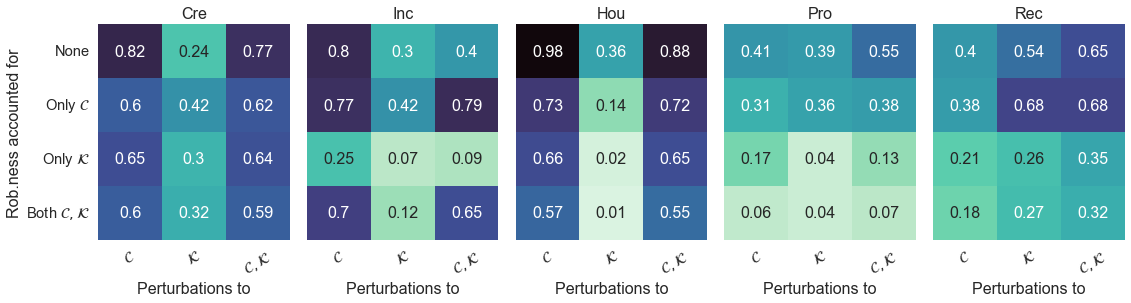

In [73]:
print("Heatmaps of invalidity")

fig, axs = plt.subplots(1,len(datasets), figsize=(16,4.5))

perturb_types = ["Only $\\mathcal{C}$", "Only $\\mathcal{K}$","Both $\\mathcal{C}, \\mathcal{K}$"]
robust_types = ["None", "Only $\\mathcal{C}$", "Only $\\mathcal{K}$","Both $\\mathcal{C}, \\mathcal{K}$"]

M = np.zeros(shape=(len(robust_types),len(perturb_types)))

for idx_d, dataset_name in enumerate(datasets):
  ax = axs[idx_d]
  curr_df = act_cost_df[act_cost_df.dataset == dataset_name]
  for i, robust_type in enumerate(robust_types):
    for j, perturb_type in enumerate(perturb_types):
      entry = curr_df[(curr_df["Robust. type"]==robust_type)&(curr_df["Perturbations to"]==perturb_type)]["Invalidity"].mean()
      M[i,j] = entry
  M = np.round(M,2)
  sns.heatmap(M, vmin=0, vmax=1, annot=True, ax=ax, cbar=False, cmap=sns.color_palette("mako_r", as_cmap=True))
  ax.set_title(fancy_names[dataset_name])
  ax.set_xticklabels(["$\\mathcal{C}$", "$\\mathcal{K}$", "$\\mathcal{C}, \\mathcal{K}$"], rotation=30)
  ax.set_xlabel("Perturbations to")
  if idx_d == 0:
    ax.set_ylabel("Rob.ness accounted for")
    ax.set_yticklabels(robust_types, rotation=0)
  else:
    ax.set_yticklabels("")
fig.tight_layout()
fig.savefig("invalidity.pdf")
plt.show()

Heatmaps of plausibility to make further intervention


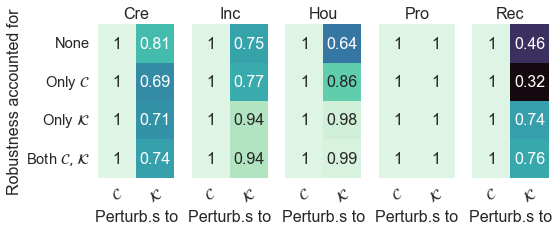

In [74]:

print("Heatmaps of plausibility to make further intervention")
fig, axs = plt.subplots(1,len(datasets), figsize=(8,3.5))
perturb_types = ["Only $\\mathcal{C}$", "Only $\\mathcal{K}$"]
robust_types = ["None", "Only $\\mathcal{C}$", "Only $\\mathcal{K}$","Both $\\mathcal{C}, \\mathcal{K}$"]
M = np.zeros(shape=(len(robust_types),len(perturb_types)))
for idx_d, dataset_name in enumerate(datasets):
  ax = axs[idx_d]
  curr_df = act_cost_df[act_cost_df.dataset == dataset_name]
  for i, robust_type in enumerate(robust_types):
    for j, perturb_type in enumerate(perturb_types):
      entry = curr_df[(curr_df["Robust. type"]==robust_type)&(curr_df["Perturbations to"]==perturb_type)]["Plausib. after perturbation"].mean()
      M[i,j] = entry
  M = np.round(M,2)
  sns.heatmap(M, vmin=0.3, vmax=1, annot=True, ax=ax, cmap=sns.color_palette("mako", as_cmap=True), cbar=False)
  ax.set_title(fancy_names[dataset_name])
  ax.set_xticklabels(["$\\mathcal{C}$", "$\\mathcal{K}$"], rotation=30)
  ax.set_xlabel("Perturb.s to")
  if idx_d == 0:
    ax.set_ylabel("Robustness accounted for")
    ax.set_yticklabels(robust_types, rotation=0)
  else:
    ax.set_yticklabels("")
fig.tight_layout()
fig.savefig("fixability.pdf")
plt.show()

Actual cost when unlucky (absolute)


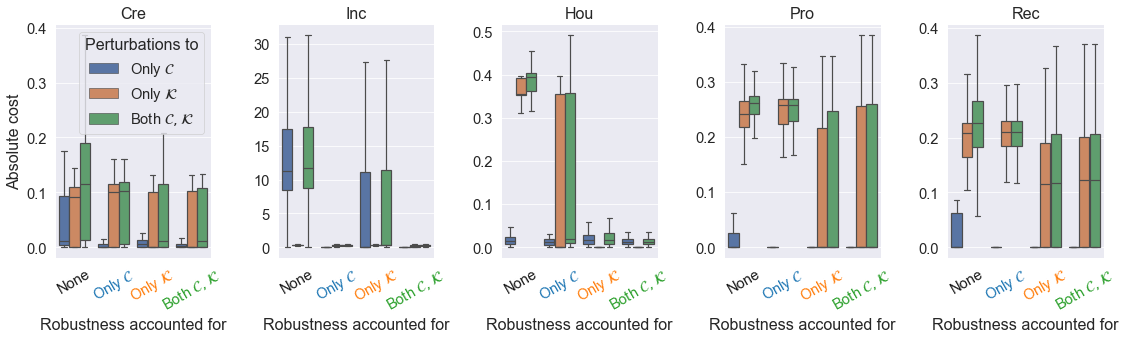

Actual cost when unlucky (relative)


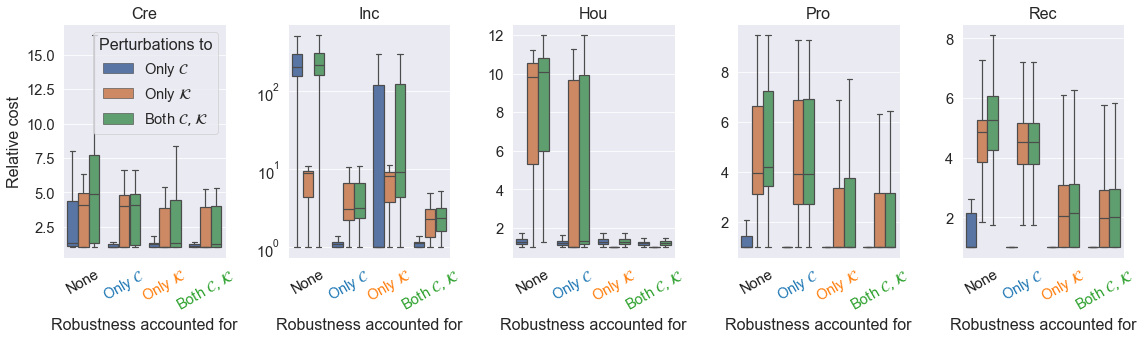

In [75]:
# plot
print("Actual cost when unlucky and perturbations happen (absolute)")
fig, axs = plt.subplots(1,len(datasets), figsize=(16,5))
for i, dataset_name in enumerate(datasets):
  curr_df = act_cost_df[(act_cost_df.dataset == dataset_name)]
  sns.boxplot(x="Robust. type", y="Abs. additional cost", data=curr_df, hue="Perturbations to", ax=axs[i], 
    showfliers=False)
  if i != 0:
    axs[i].get_legend().remove()
  #if dataset_name == "adult":
  #  axs[i].set_yscale("log")
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=30)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xlabel("Robustness accounted for")
  axs[i].set_ylabel("Absolute cost")
  if i != 0:
    axs[i].set_ylabel("")
  [t.set_color(i) for (i,t) in
    zip(['k','tab:blue','tab:orange','tab:green'],axs[i].xaxis.get_ticklabels())]
fig.tight_layout()
fig.savefig("additional_abs_cost_unlucky.pdf")
plt.show()


# plot
print("Actual cost when unlucky and perturbations happen (relative)")
fig, axs = plt.subplots(1,len(datasets), figsize=(16,5))
for i, dataset_name in enumerate(datasets):
  curr_df = act_cost_df[(act_cost_df.dataset == dataset_name)]
  sns.boxplot(x="Robust. type", y="Rel. additional cost", data=curr_df, hue="Perturbations to", ax=axs[i], showfliers=False)
  #sns.barplot(x="Robust. type", y="Rel. additional cost", data=curr_df, hue="Perturbations to", ax=axs[i]) 
  if i != 0:
    axs[i].get_legend().remove()
  if dataset_name == "adult":
    axs[i].set_yscale("log")
  axs[i].set_xticklabels(axs[i].get_xticklabels(),rotation=30)
  axs[i].set_title(fancy_names[dataset_name])
  axs[i].set_xlabel("Robustness accounted for")
  axs[i].set_ylabel("Relative cost")
  if i != 0:
    axs[i].set_ylabel("")
  [t.set_color(i) for (i,t) in
    zip(['k','tab:blue','tab:orange','tab:green'],axs[i].xaxis.get_ticklabels())]
fig.tight_layout()
fig.savefig("additional_rel_cost_unlucky.pdf")
plt.show()